---


Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. Name it *'LastName_FirstName_T2.2.ipynb'*. <ins>This is the master notebook so you will not be able to save your changes without copying it !</ins> Once you click on that, make sure you are working on that version of the notebook so that your work is saved.



---

### In this Colab, we explore the effect of TF Lite Optimization on size, performance, and accuracy on an Image Classification task. For best performance on this Colab make sure you are using a **GPU runtime!** The runtime can be changed by selecting: ```runtime -> change runtime type``` and selecting GPU from the hardware accelerator dropdown.

### Import necessary libraries



In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


We import the following libraries -

1.   [tensorflow](https://www.tensorflow.org/) - open source library to develop and train ML models
2. [tensorflow_hub](https://www.tensorflow.org/hub) - repository of trained machine learning models
3. [tensorflow_datasets](https://www.tensorflow.org/datasets) - a collection of ready-to-use datasets
4.   [matplotlib](https://matplotlib.org/) - visualization of data in Python
5.   [numpy](https://numpy.org/) - scientific computing in Python

In [ ]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import pathlib

### Load Cats vs Dogs Dataset

The Dataset is loaded and split into train, validation, and test datasets based on the specified split. Train - 80%, Validation - 10%, and Test - 10%.

You can read more about the API [here](https://www.tensorflow.org/datasets/api_docs/python/tfds/load).

In [ ]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# load in our dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# display how much data we have
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print()
print("Number of data samples:", num_examples)
print("Number of classes:", num_classes)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteK9EWT7/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.

Number of data samples: 23262
Number of classes: 2


### Visualize Training Examples

Let's visualize a few examples. We see that the dataset contains images of different sizes! We will convert them to (224, 224, 3) sized images later!

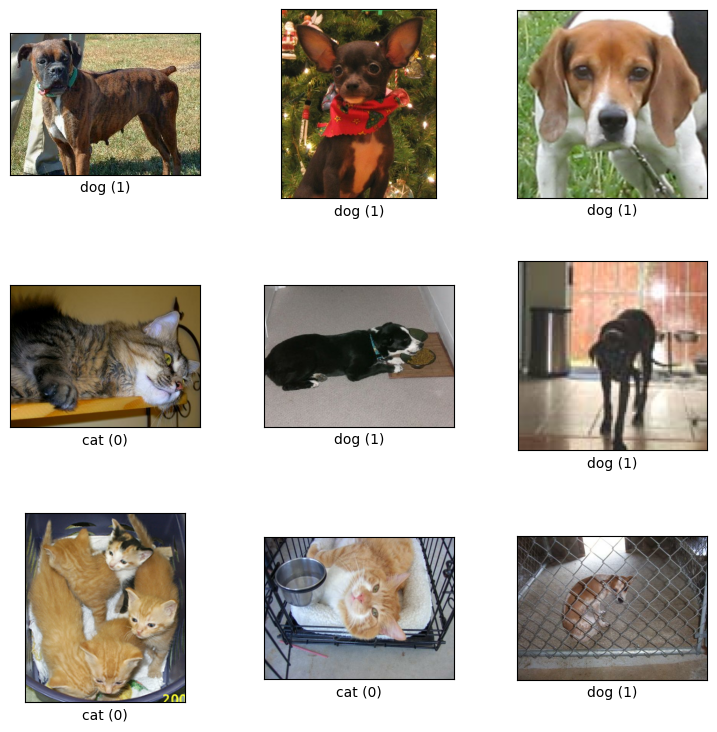

In [ ]:
vis = tfds.visualization.show_examples(raw_train, metadata)

We reshape the images to (224, 224, 3) and split the dataset into batches to reduce memory requirement. Here's the documentation for the following - [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map), [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take).

In [ ]:
# format images to have normalized pixels
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label


# split the data in training, validation, and test datasets
BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

print("Number of training batches:", len(train_batches))

# display the shape of our data
for image_batch, label_batch in train_batches.take(1):
    pass


print("Shape of one batch of images:", image_batch.shape)
print("label example:", label_batch[10].numpy())


Number of training batches: 582
Shape of one batch of images: (32, 224, 224, 3)
label example: 0


### Define pre-trained model

We will be using the concept of **Transfer Learning** to train our model - tuning the weights of an already trained model to fit our dataset. We take advantage of the fact that the features learned in the initial few layers by a network on any dataset are fundamental and could be tranferable to other datasets (like lines, basic shapes etc). This prevents us from training our model from scratch which would reduce the amount of time needed for training. You can read more about transfer learning [here](https://machinelearningmastery.com/transfer-learning-for-deep-learning/).

Here, we download the weights of a MobileNet model pre-trained on the ImageNet Dataset from TensorFlow Hub. We use these weights to subsequently train our custom neural network. You can read more about this popular neural network model [here](https://arxiv.org/pdf/1801.04381.pdf).

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280)       # (pre-trained model, input pixel size, output feature vector size)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))


Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


---


**Question 1**: Why do we use Transfer Learning?

**Answer:** This is to ease our training process. We can simply take the pre-trained data rather than doing it from scratch ourselves.

---

### Define our model

We will extract the feature extractor from the pre-trained model which form the main layers of our model. We will then add a dense layer with the number of neurons equal to the number of classes to complete our model for our dataset.

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)



# model layers stacked
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])



Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4


---


**Question 2**: Can you think of why we set the trainable parameter as 'False' for the pre-trained model?

**Answer:** Because we are using Transfer learning, there's no need to train.


---

Let's look at a summary of our model!

In [ ]:
#<YOUR CODE HERE>
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Finally, we define our loss and optimizer and compile our model!

In [ ]:
LOSS = 'sparse_categorical_crossentropy'
OPT = 'adam'


model.compile(optimizer=OPT,
                  loss=LOSS,
                  metrics=['accuracy'])

### Train model
Since we are doing transfer learning to fine tune a pre-trained model to our dataset we only need to use 1 Epochs.

In [ ]:
EPOCHS = 1

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

582/582 [==============================] - 48s 54ms/step - loss: 0.0478 - accuracy: 0.9844 - val_loss: 0.0379 - val_accuracy: 0.9871


We see that even with just 5 epochs, our model is doing pretty well! Let's go ahead and save this model.

### Save Model

The saved model cab be found in the File/ tab on the left!

In [ ]:
CATS_VS_DOGS_SAVED_MODEL = "saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

##1. Model1: TFLite model


In the below code cell, we generate model1.tflite.


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL) #<YOUR CODE HERE>
tflite_model = converter.convert()


tflite_models_dir = pathlib.Path("/content/")
tflite_model_file = tflite_models_dir/'model1.tflite'
print("Size of model1:", tflite_model_file.write_bytes(tflite_model))


Size of model1: 8875280


***Hint:*** Use `tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)` to instantiate the converter.

We see that the tflite model is around 9MB!

## 2. Model2: TFLite model with Dynamic Range Quantization

We add the ```converter.optimizations = [tf.lite.Optimize.DEFAULT]``` line. Run the below code to generate model2.tflite, which will have optimizations added -- you should see a much smaller file size. The model weights are now represented as **8-bit precision** values as opposed to **Float32**, therefore creating a 4x reduction in size! Read more [here](https://www.tensorflow.org/lite/performance/post_training_quant).

\

**Note:** tf.lite.Optimize has changed and the OPTIMIZE_FOR_SIZE and OPTIMIZE_FOR_LATENCY options are now deprecated and are the same as DEFAULT: https://www.tensorflow.org/api_docs/python/tf/lite/Optimize

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

converter.optimizations = [tf.lite.Optimize.DEFAULT]   # optimization

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/content/")

tflite_model_file = tflite_models_dir/'model2.tflite'
tflite_model_file.write_bytes(tflite_model)


2509752

## 3. Model3: TFLite model with Integer Quantization


Integer quantization is an optimization strategy that converts **32-bit floating-point** numbers (such as weights and activation outputs) to the nearest **8-bit fixed-point** numbers. We include a representative dataset and set the supported ops as shown. Run the below code to generate model3.tflite which will have optimizations added, along with quantization from the representative dataset. Read more [here](https://www.tensorflow.org/lite/performance/post_training_integer_quant).

**Note:** it might be slightly larger than model2.tflite!

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

converter.optimizations = [tf.lite.Optimize.DEFAULT]    # optimization

def representative_data_gen():                          # quantization from representative dataset
    for input_value, _ in test_batches.take(100):
        yield [input_value]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/content/")

tflite_model_file = tflite_models_dir/'model3.tflite'
tflite_model_file.write_bytes(tflite_model)


OSError: ignored

## Inference
Now we will test the accuracy of the three models! After you run each model you will get the number of correct predictions and then you can plot some results and see if you notice any wrong predictions!

We use the **'Interpreter'** to run inference on our TFLite models!

\

**Important Notes:**


1.   Changes have been made to the TFLite Interpreter that further optimize it for mobile use at the expense of speed in Colab i.e, these models are optimized for hardware and will run slower on Colab.
2.   Inference Time can be truly appreciated when run on actual hardware such as the Raspberry Pi.




In [ ]:
from tqdm import tqdm

# Load TFLite model and allocate tensors.
tflite_model_file = 'model1.tflite'                 # Change the filename here for Model 2 and 3
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

score = 0
for item in range(0,100):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print()
print("Out of 100 predictions I got " + str(score) + " correct")



100%|██████████| 100/100 [00:02<00:00, 38.68it/s]


Out of 100 predictions I got 100 correct


---


**Question 3**: Note down the number of Iterations/second for all 3 models.

**Answer:**


1.   Model1 : 38.10 it/s
2.   Model2 : 24.23 it/s
3.   Model3 : 63.15 it/s



---

---


**Question 4**: Note down the number of correct predictions for all 3 models.

**Answer:**


1.   Model1 : 100
2.   Model2 : 100
3.   Model3 : 99



---

## Visualization

Here, we define a utility function to plot test images with their predictions. We plot the correct predictions with green titles and wring predictions with red titles.

In [ ]:
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

You can use the slider below to determine the number of examples you want to plot. If you get wrong predictions in any model, observe it in the output below (Hint: make max_index = 100 to see the wrong prediction)

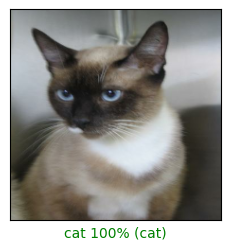

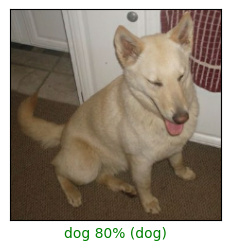

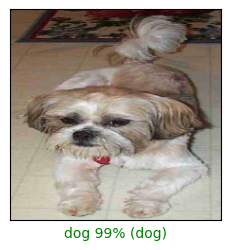

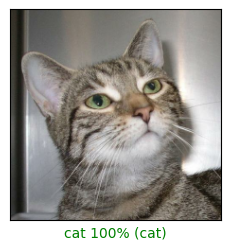

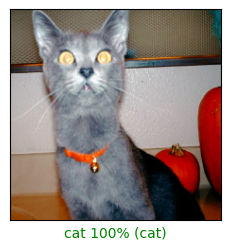

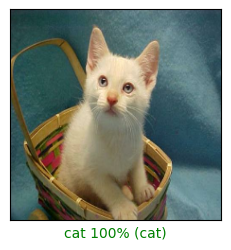

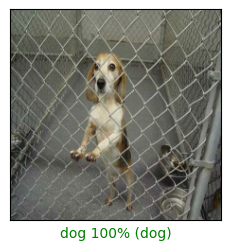

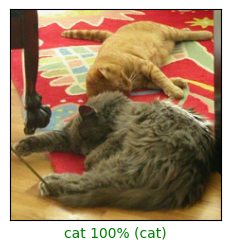

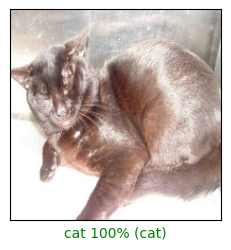

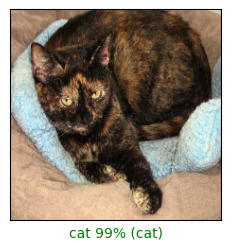

In [ ]:
max_index = 10 #@param {type:"slider", min:1, max:100, step:1}
for index in range(0, max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()



---



# Additional Pointers



You can use the below line of code to delete the contents (subdirectories and files) of a directory.



In [ ]:
#!rm -r '/content/saved_model/'*
#!rm -r '/content/saved_model/'

You can use the below line of code to delete a file.


In [ ]:
#!rm '/content/model1.tflite'
#!rm '/content/model2.tflite'
#!rm '/content/model3.tflite'